In [1]:
"""Test the radiosity.Radiosity module."""
import sparapy as sp
import pyfar as pf
import tqdm
from datetime import datetime
import numpy as np
import tracemalloc
import matplotlib.pyplot as plt
%matplotlib ipympl

In [2]:
X = 5
Y = 4
Z = 3
patch_size = 1
length_histogram = 0.1
time_resolution = 1/10000
speed_of_sound = 343

absorption = 0.1
S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)

radiosity = sp.DRadiosityFast.from_polygon(
    walls, patch_size)
# create directivity
source = sp.geometry.SoundSource([2, 2, 2], [0, 1, 0], [0, 0, 1])

sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

radiosity.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)
radiosity.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))
radiosity.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))



reverberation distance is 0.432443127050225m
reverberation time is 0.9760640552871188s


In [ ]:

# # C. Form factors
# radi.source = source
# if len(radi.patch_list) > 1:
#     for patches in radi.patch_list:
#         patches.calculate_form_factor(radi.patch_list)


# for patches in radi.patch_list:
#     patches.init_energy_exchange(
#         radi.max_order_k, radi.ir_length_s, source,
#         sampling_rate=radi.sampling_rate)

# # D. Energy exchange between patches
# if len(radi.patch_list) > 1:
#     for k in range(1, radi.max_order_k+1):
#         for patches in radi.patch_list:
#             patches.calculate_energy_exchange(
#                 radi.patch_list, k, speed_of_sound=radi.speed_of_sound,
#                 E_sampling_rate=radi.sampling_rate)

radi = sp.radiosity.Radiosity(
    walls, patch_size, 0, length_histogram,
    speed_of_sound=speed_of_sound, sampling_rate=1/time_resolution)
# C. Form factors
radi.source = source
if len(radi.patch_list) > 1:
    for patches in radi.patch_list:
        patches.calculate_form_factor(radi.patch_list)

/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


In [ ]:
# run simulation
print('baking geometry...')
radiosity.bake_geometry(algorithm='order')


baking geometry...


In [ ]:
source_pos = np.array([4, 3, 2])

radiosity.init_source_energy(source_pos, algorithm='order')

In [ ]:
# test energy at receiver
receiver_pos = [.3, .4, .2]
receiver = sp.geometry.Receiver(receiver_pos, [0, 1, 0], [0, 0, 1])
threshold_db = -70
histograms = []
histograms_old = []
ks = [0]
time_slow = np.zeros(len(ks))
time_fast = np.zeros(len(ks))
memory_slow = np.zeros(len(ks))
memory_fast = np.zeros(len(ks))
for i_k in range(len(ks)):
    k = ks[i_k]
    print(f'Calculating energy exchange old for k={k}...')
    tracemalloc.start()
    start = datetime.now()
    radi.max_order_k = k
    # old implementation
    for patches in radi.patch_list:
        patches.init_energy_exchange(
            k, radi.ir_length_s, source,
            sampling_rate=radi.sampling_rate)

    # D. Energy exchange between patches
    if len(radi.patch_list) > 1:
        for k in range(1, radi.max_order_k+1):
            for patches in radi.patch_list:
                patches.calculate_energy_exchange(
                    radi.patch_list, k, speed_of_sound=radi.speed_of_sound,
                    E_sampling_rate=radi.sampling_rate)
    histograms_old.append(radi.energy_at_receiver(receiver, ignore_direct=False))

    delta = (datetime.now() - start)
    time_slow[i_k] = (delta.seconds*1e6 + delta.microseconds)
    memory_slow[i_k] = tracemalloc.get_traced_memory()[1] # get peak memory

    print(f'Calculating energy exchange new for k={k}...')
    # new implementation
    tracemalloc.start()
    start = datetime.now()
    histogram = radiosity.calculate_energy_exchange_receiver(
        receiver_pos, speed_of_sound, time_resolution, length_histogram,
        threshold=0, max_time=np.inf, max_depth=k, algorithm='order', recalculate=True)
    delta = (datetime.now() - start)
    time_fast[i_k] = (delta.seconds*1e6 + delta.microseconds)
    memory_fast[i_k] = tracemalloc.get_traced_memory()[1] # get peak memory
    histograms.append(histogram.T)
irs_new = np.array(histograms).squeeze()
irs_new_old = np.array(histograms_old).squeeze()
reverberation = pf.Signal(irs_new, sampling_rate=1/time_resolution)
reverberation_old = pf.Signal(irs_new_old, sampling_rate=1/time_resolution)

Calculating energy exchange old for k=0...
n_old = 15
n_old = 40
n_old = 68
n_old = 37
n_old = 52
n_old = 76
n_old = 65
n_old = 75
n_old = 93
n_old = 94
n_old = 101
n_old = 115
n_old = 123
n_old = 128
n_old = 140
n_old = 105
n_old = 111
n_old = 124
n_old = 110
n_old = 116
n_old = 129
n_old = 123
n_old = 128
n_old = 140
n_old = 140
n_old = 145
n_old = 155
n_old = 161
n_old = 165
n_old = 174
n_old = 8
n_old = 33
n_old = 61
n_old = 90
n_old = 35
n_old = 47
n_old = 70
n_old = 97
n_old = 64
n_old = 71
n_old = 88
n_old = 110
n_old = 93
n_old = 98
n_old = 111
n_old = 130
n_old = 122
n_old = 126
n_old = 137
n_old = 152
n_old = 81
n_old = 87
n_old = 102
n_old = 121
n_old = 88
n_old = 94
n_old = 107
n_old = 126
n_old = 103
n_old = 108
n_old = 120
n_old = 137
n_old = 124
n_old = 128
n_old = 138
n_old = 153
n_old = 147
n_old = 150
n_old = 159
n_old = 172
n_old = 12
n_old = 39
n_old = 67
n_old = 34
n_old = 50
n_old = 74
n_old = 62
n_old = 72
n_old = 91
n_old = 91
n_old = 98
n_old = 112
n_old = 137


In [ ]:
E_reverb_analytical = 4/A


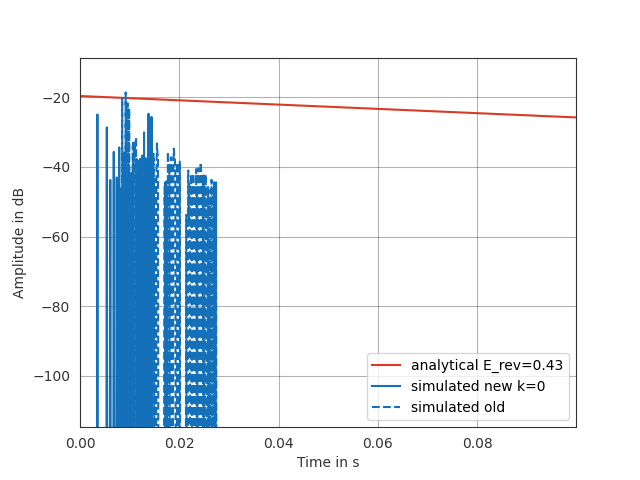

In [ ]:
t = reverberation_old.times
w_0 = E_reverb_analytical/ V # Kuttruff Eq 4.7
t_0 = 0.03
reverberation_analytic = w_0 * np.exp(+(speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0)) # Kuttruff Eq 4.10
reverberation_analytic = pf.Signal(reverberation_analytic, sampling_rate=1/time_resolution)
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}', color='r')
color = ['b', 'g', 'c', 'm', 'y', 'k']
for i in range(reverberation.cshape[0]):
    # e_rel = (E_reverb[i]/E_reverb_analytical)
    if reverberation.n_samples > 1:
        pf.plot.time(
            reverberation[i], dB=True, log_prefix=10,
            label=f'simulated new k={ks[i]}',
            linestyle='-', color=color[i%len(color)])
    pf.plot.time(
        reverberation_old[i], dB=True, log_prefix=10,
        label='simulated old',
        linestyle='--', color=color[i%len(color)])
plt.legend()
plt.show()

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_28254/2016191948.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


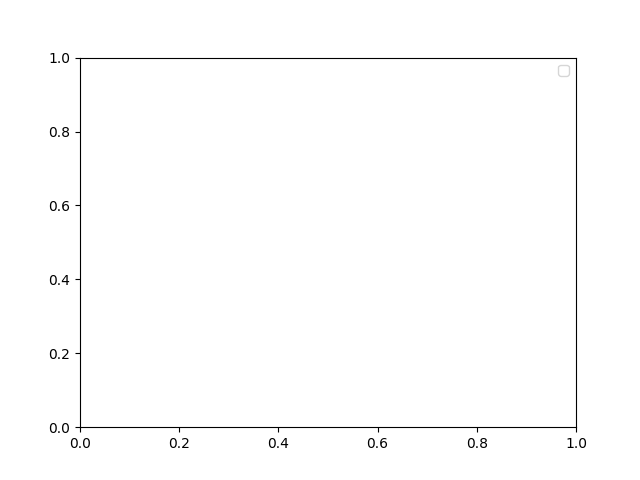

In [ ]:
plt.figure()
color = ['b', 'g', 'c', 'm', 'y', 'k']
for i in range(reverberation.cshape[0]-1):
    # e_rel = (E_reverb[i]/E_reverb_analytical)
    if reverberation.n_samples > 1:
        pf.plot.time(
            reverberation[i+1]-reverberation[i], dB=True, log_prefix=10,
            label=f'simulated new k={ks[i]}',
            linestyle='-', color=color[i%len(color)])
    pf.plot.time(
        reverberation_old[i+1]-reverberation_old[i], dB=True, log_prefix=10,
        label='simulated old',
        linestyle='--', color=color[i%len(color)])
plt.legend()
plt.show()

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_28254/609846833.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


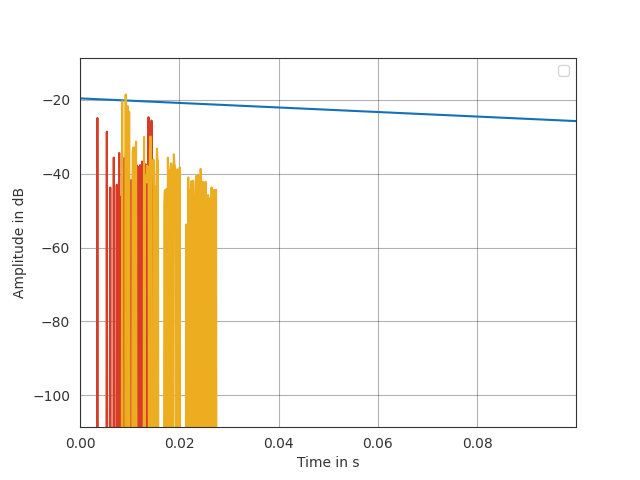

In [ ]:
plt.figure()
all = pf.utils.concatenate_channels([
    reverberation_analytic,
    reverberation,
    reverberation_old,
    ])
pf.plot.time(
    all, dB=True, log_prefix=10,)
# color = ['b', 'g', 'c', 'm', 'y', 'k']
# for i in range(reverberation.cshape[0]):
#     # e_rel = (E_reverb[i]/E_reverb_analytical)
#     pf.plot.time(
#         reverberation[i], dB=True, log_prefix=10,
#         label=f'simulated new k={ks[i]}',
#         linestyle='-', color=color[i])
#     pf.plot.time(
#         reverberation_old[i], dB=True, log_prefix=10,
#         label='simulated old',
#         linestyle='--', color=color[i])
plt.legend()
plt.show()

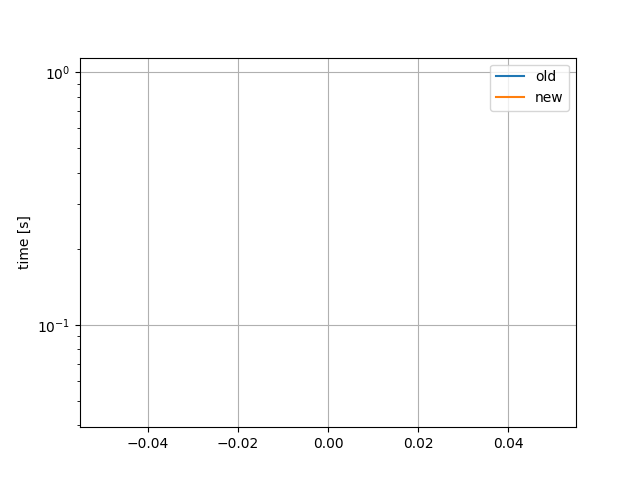

In [ ]:
plt.figure()
ax = plt.gca()
ax.semilogy(ks, time_slow*1e-6, label='old')
ax.semilogy(ks, time_fast*1e-6, label='new')
ax.set_ylabel('time [s]')
ax.grid()
plt.legend()

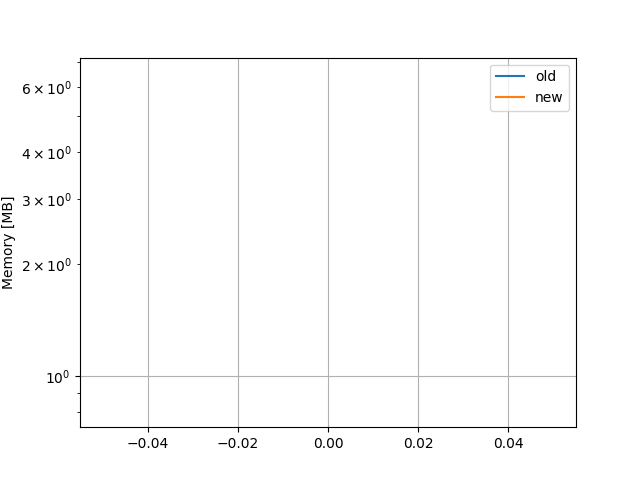

In [ ]:
plt.figure()
ax = plt.gca()
ax.semilogy(ks, memory_slow*1e-6, label='old')
ax.semilogy(ks, memory_fast*1e-6, label='new')
ax.grid()
ax.set_ylabel('Memory [MB]')
plt.legend()

In [ ]:
memory_slow*1e-6

array([0.810183])

In [ ]:
memory_fast*1e-6

array([6.477204])